In [1]:
%load_ext autoreload
%autoreload 2

import aerosandbox as asb
import numpy as np
from airfoil_toolkit.airfoil import Airfoil

In [2]:
airfoil = Airfoil(name="NACA0012")
airfoil.draw(backend="plotly")

In [ ]:
airfoil.write_dat(f"./airfoils/{airfoil.name}.dat")

In [3]:
from airfoil_toolkit.xfoil import run_xfoil
output = run_xfoil(airfoil, 0, 80, 2)
output

{'alpha': array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 40., 42., 44., 46., 48., 50., 52.,
        54., 56., 58., 60., 64., 68., 72., 76., 78., 80.]),
 'CL': array([-0.    ,  0.309 ,  0.5352,  0.6973,  0.8494,  1.007 ,  1.0952,
         0.9662,  0.5383,  0.5327,  0.5533,  0.5807,  0.6071,  0.6323,
         0.6547,  0.674 ,  0.6906,  0.7039,  0.7136,  0.7216,  0.7195,
         0.714 ,  0.7046,  0.6917,  0.6756,  0.6563,  0.6342,  0.6096,
         0.5825,  0.5535,  0.4905,  0.4229,  0.3529,  0.2828,  0.2482,
         0.2144]),
 'CD': array([0.01018, 0.01065, 0.01176, 0.01512, 0.02075, 0.02976, 0.04454,
        0.07919, 0.16963, 0.1903 , 0.21064, 0.23131, 0.25293, 0.27513,
        0.29789, 0.32108, 0.34471, 0.36794, 0.39031, 0.43267, 0.45158,
        0.46884, 0.48436, 0.49684, 0.50765, 0.51476, 0.51986, 0.52143,
        0.52033, 0.51614, 0.49968, 0.47352, 0.43977, 0.40086, 0.38033,
        0.35902]),
 'CDp': array([0.00386, 0

In [24]:
output = airfoil.generate_polars_xfoil(alpha_i=-5, alpha_f=20, alpha_step=0.25)





















































































Running XFoil to generate polars for Airfoil 'NACA0012':: 100%|██████████| 12/12 [07:25<00:00, 37.15s/it]


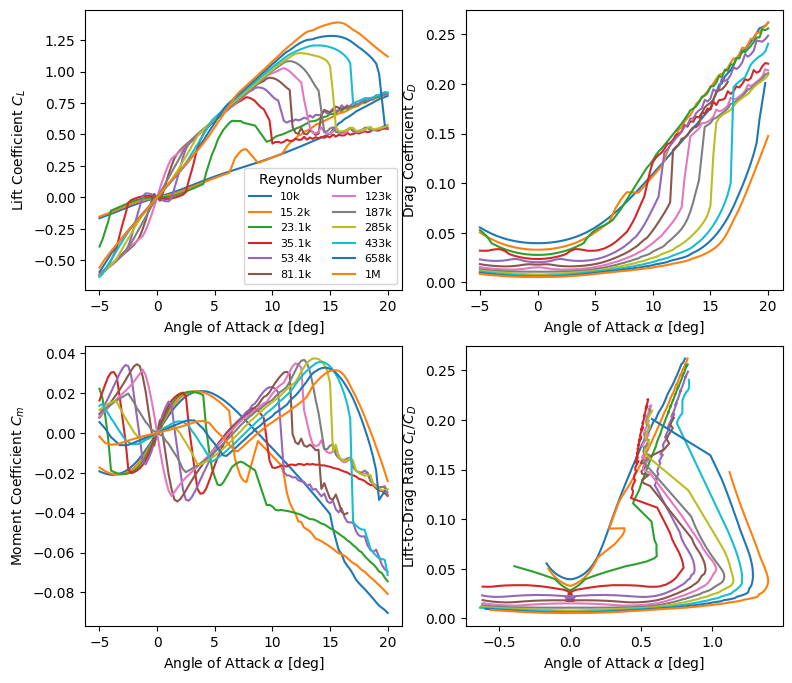

In [26]:
airfoil.plot_polars()

In [ ]:
type(airfoil.coordinates)

In [3]:
airfoil_database_path = asb._asb_root / "geometry" / "airfoil" / "airfoil_database"

UIUC_airfoils = [
    asb.Airfoil(name=filename.stem).normalize()
    for filename in airfoil_database_path.iterdir() if filename.suffix == ".dat"
]

In [11]:
rand_airfoil = lambda: np.random.choice(UIUC_airfoils)
airfoil = rand_airfoil()

In [ ]:
airfoil.generate_polars()
airfoil.plot_polars()